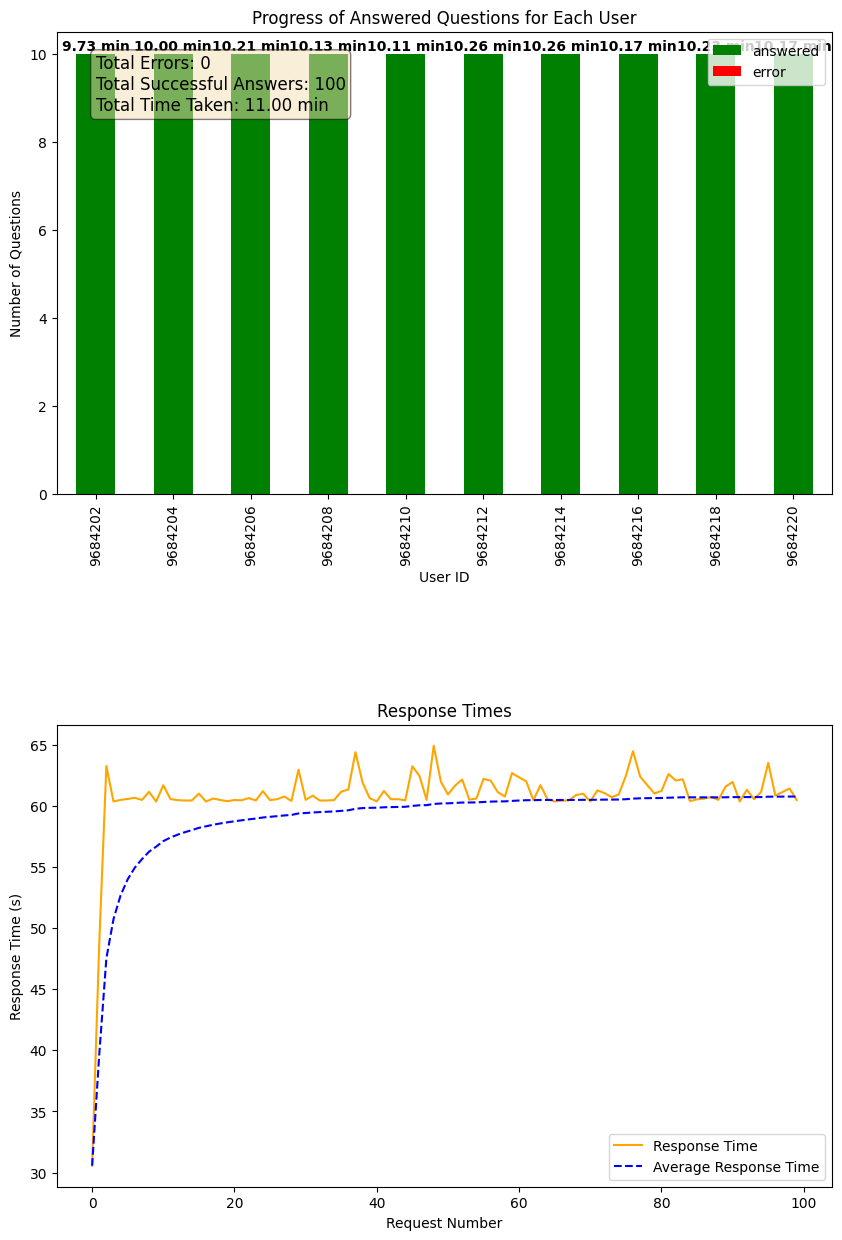

Volume testing completed with 10 users and 274 questions.
An error occurred during analysis: 'input_variables'
Results saved to volume-test-run-20240529-2356.xlsx


In [7]:
import os
import pandas as pd
import random
import requests
import time
import certifi
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, clear_output
from threading import Lock
from datetime import datetime
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import sys
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
import urllib3

# Suppress only the single InsecureRequestWarning from urllib3 needed
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Set the AWS profile and certificate bundle
os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# bedrock model
model_id = "meta.llama3-8b-instruct-v1:0"

# Configuration values
auth_client_secret = "01226C5F-4047-48ED-BE6F-574952C8EBBF"
auth_url = "https://dv-id.mybenefitexpress.com/connect/token"
NUM_QUESTIONS_PER_USER = 10  # Constant number of questions each user will take

def validate_file(file_path):
   
    try:
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        print(f"Exception occurred during file validation: {e}")
        return False, 0

def validate_token(token):
    
    url = 'https://benefit-assistant.dv.mybenefitexpress.com/v1.0/benefitassistant/Session'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    try:
        response = requests.get(url, headers=headers, verify=False)  # verify=False for local testing, remove in production
        return response.status_code == 200
    except requests.exceptions.RequestException as e:
        print(f"Exception occurred during token validation: {e}")
        return False

def retrieve_token(user_id, client_id, client_secret, auth_url):
   
    data = {
        "grant_type": "client_credentials",
        "userid": user_id,
        "tenant_id": client_id,
        "logged_in_tenant_id": client_id,
        "logged_in_user_id": user_id,
        "client_id": "mbe50",
        "client_secret": client_secret,
        "scope": "externalidentityprovider"
    }
    
    try:
        response = requests.post(auth_url, data=data)
        response.raise_for_status()
        token_data = response.json()
        
        if "access_token" in token_data:
            token = token_data['access_token']
            return token.strip("'")  # Strip any surrounding single quotes from the token
        else:
            raise Exception("Unable to retrieve access token from IdentityServer.")
    except requests.RequestException as ex:
        print(f"An error occurred during authentication: {ex}")
        return ""

def refresh_bedrock_client():
    
    try:
        session = boto3.Session(profile_name=os.environ["AWS_PROFILE"])
        credentials = session.get_credentials()
        credentials = credentials.get_frozen_credentials()

        bedrock_client = boto3.client(
            service_name="bedrock-runtime",
            region_name="us-east-1",
            aws_access_key_id=credentials.access_key,
            aws_secret_access_key=credentials.secret_key,
            aws_session_token=credentials.token
        )
        return bedrock_client
    except (NoCredentialsError, PartialCredentialsError) as e:
        print(f"Error refreshing AWS credentials: {str(e)}")
        return None

def chat(question, token):
   
    url = f'https://benefit-assistant.dv.mybenefitexpress.com/v1.0/benefitassistant/Assistant/llm-response?question={question}'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    try:
        response = requests.get(url, headers=headers, verify=False)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        return {"error": str(e)}

def simulate_user_questions(user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, token, start_time, num_questions_per_user):
   
    combined = list(zip(question_ids, questions))
    random.shuffle(combined)
    selected_questions = random.sample(combined, min(num_questions_per_user, len(combined)))
    
    for question_id, question in selected_questions:
        try:
            start_time_question = time.time()
            response = chat(question, token)
            end_time_question = time.time()
            time_taken = end_time_question - start_time_question
            user_time[user_id] += time_taken
            response_times.append(time_taken)
            avg_response_times.append(sum(response_times) / len(response_times))
            
            if "error" in response:
                raise Exception(response["error"])
            
            answer = response.get("answer", "")
            user_progress[user_id]["answered"] += 1
            results.append([user_id, question, answer, ""])
        except Exception as e:
            error_info = f"Error occurred for user {user_id}, question ID {question_id}, question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1
            results.append([user_id, question, "", str(e)])

        with lock:
            update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time)

def update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time):
    
    progress_df = pd.DataFrame(user_progress).T
    fig, axes = plt.subplots(2, 1, figsize=(10, 15))

    # Adjust layout to add space between the plots
    plt.subplots_adjust(hspace=0.5)

    # Plot progress of answered questions for each user
    progress_df.plot(kind='bar', stacked=True, color=['green', 'red'], ax=axes[0])
    axes[0].set_xlabel('User ID')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Progress of Answered Questions for Each User')
    axes[0].yaxis.get_major_locator().set_params(integer=True)

    # Annotate the bars with the time taken
    for p in axes[0].patches:
        width, height = p.get_width(), p.get_height()
        if height > 0:
            x, y = p.get_xy()
            user_id = progress_df.index[int(x + width / 2)]
            if user_progress[user_id]["answered"] > 0:  # Annotate only once per user
                time_text = f"{user_time[user_id] / 60:.2f} min"
                axes[0].annotate(time_text, (x + width / 2, height), 
                                 ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    # Calculate total elapsed time
    total_time_taken = (time.time() - start_time) / 60  # in minutes

    # Display number of errors, successful answers, and total time taken
    total_errors = sum(user['error'] for user in user_progress.values())
    total_successes = sum(user['answered'] for user in user_progress.values())
    textstr = f'Total Errors: {total_errors}\nTotal Successful Answers: {total_successes}\nTotal Time Taken: {total_time_taken:.2f} min'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)

    # Plot response times and average response times
    axes[1].plot(response_times, label='Response Time', color='orange')
    axes[1].plot(avg_response_times, label='Average Response Time', linestyle='--', color='blue')
    axes[1].set_xlabel('Request Number')
    axes[1].set_ylabel('Response Time (s)')
    axes[1].set_title('Response Times')
    axes[1].legend()

    clear_output(wait=True)
    display(fig)
    plt.close(fig)

def analyze_results(user_count, question_count, total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log):
    
    results_summary = f"""
    Volume Testing Results Summary:
    - Number of users: {user_count}
    - Number of questions: {question_count}
    - Total Successful Answers: {total_successes}
    - Total Errors: {total_errors}
    - Total Time Taken: {total_time_taken:.2f} minutes
    - Average Response Time: {sum(avg_response_times) / len(avg_response_times):.2f} seconds
    - Maximum Response Time: {max(response_times):.2f} seconds
    - Minimum Response Time: {min(response_times):.2f} seconds
    
    Error Log:
    {error_log}
    """
    
    question = f"""
    We are testing an API. Please analyze the following volume test results and provide insights on what is good, what problems exist, and how to improve performance if there are any issues.
    
    {results_summary}
    """
    
    global bedrock_client  # Ensure we use the global bedrock_client
    llm = BedrockLLM(
        model_id=model_id,
        client=bedrock_client,
        model_kwargs={"max_gen_len": 512, "temperature": 0.5}
    )

    prompt = PromptTemplate(template=question)

    try:
        bedrock_chain = LLMChain(llm=llm, prompt=prompt)
        response = bedrock_chain({'question': question})
        return response['text']
    except Exception as e:
        if "ExpiredTokenException" in str(e):
            print("Token expired. Refreshing token...")
            bedrock_client = refresh_bedrock_client()
            if bedrock_client is None:
                print("Failed to refresh token. Continuing without analysis.")
                return "Failed to refresh token. Analysis not performed."
            
            llm = BedrockLLM(
                model_id=model_id,
                client=bedrock_client,
                model_kwargs={"max_gen_len": 512, "temperature": 0.5}
            )
            bedrock_chain = LLMChain(llm=llm, prompt=prompt)
            try:
                response = bedrock_chain({'question': question})
                return response['text']
            except Exception as e:
                print(f"An error occurred during analysis after token refresh: {str(e)}")
                return f"An error occurred during analysis after token refresh: {str(e)}"
        else:
            print(f"An error occurred during analysis: {str(e)}")
            return f"An error occurred during analysis: {str(e)}"

# Placeholder for user input file paths
users_file_path = "wex-users.xlsx"  # Replace with the actual path
questions_file_path = "wex-questions.xlsx"  # Replace with the actual path

# Validate the files
is_users_valid, user_count = validate_file(users_file_path)
is_questions_valid, question_count = validate_file(questions_file_path)

if not is_users_valid or not is_questions_valid:
    print("One or both of the uploaded files are not valid Excel files.")
    sys.exit(1)

# Load user data from the users file
users = pd.read_excel(users_file_path)
user_ids = users["user-id"].tolist()
client_ids = users["client-id"].tolist()

# Initialize a dictionary to store tokens
user_tokens = {}

# Retrieve and validate tokens for each user
for user_id, client_id in zip(user_ids, client_ids):
    try:
        token = retrieve_token(user_id, client_id, auth_client_secret, auth_url)
        if validate_token(token):
            user_tokens[user_id] = token
        else:
            print(f"Error: Invalid Bearer token for user {user_id}.")
    except Exception as e:
        print(f"Error retrieving token for user {user_id}: {str(e)}")

# Proceed with the volume test using the tokens
if not user_tokens:
    print("No valid tokens retrieved. Exiting...")
    sys.exit(1)

error_log = []
response_times = []
avg_response_times = []
results = []

users = pd.read_excel(users_file_path)
questions_df = pd.read_excel(questions_file_path)

if 'Question' not in questions_df.columns or 'question-id' not in questions_df.columns:
    print("Error: The 'question-id' and/or 'Question' column is not found in the questions file.")
    print(f"Available columns are: {questions_df.columns.tolist()}")
    sys.exit(1)
elif 'user-id' not in users.columns:
    print("Error: The 'user-id' column is not found in the users file.")
    print(f"Available columns are: {users.columns.tolist()}")
    sys.exit(1)
else:
    questions = questions_df["Question"].tolist()
    question_ids = questions_df["question-id"].tolist()
    user_ids = users["user-id"].tolist()

    print(f"Number of user records: {user_count}")
    print(f"Number of questions: {question_count}")

    user_progress = {user_id: {"answered": 0, "error": 0} for user_id in user_ids}
    user_time = {user_id: 0 for user_id in user_ids}
    lock = Lock()

    bedrock_client = boto3.client(
        service_name="bedrock-runtime",
        region_name="us-east-1"
    )

    llm = BedrockLLM(
        model_id=model_id,
        client=bedrock_client,
        model_kwargs={"max_gen_len": 512, "temperature": 0.5}
    )

    start_time = time.time()  # Capture the start time

    with ThreadPoolExecutor(max_workers=len(user_ids)) as executor:
        futures = []
        for user_id in user_ids:
            token = user_tokens.get(user_id)
            if token:
                futures.append(executor.submit(simulate_user_questions, user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, token, start_time, NUM_QUESTIONS_PER_USER))
                time.sleep(5)

        for future in as_completed(futures):
            future.result()

    total_time_taken = (time.time() - start_time) / 60  # Calculate the total elapsed time

    print(f"Volume testing completed with {user_count} users and {question_count} questions.")
    if error_log:
        print("Errors occurred during volume testing. Here are the details:")
        for error in error_log:
            print(error)

    try:
        # Analyze the results using the LLM
        total_successes = sum(user['answered'] for user in user_progress.values())
        total_errors = sum(user['error'] for user in user_progress.values())
        analysis = analyze_results(len(user_ids), len(questions), total_successes, total_errors, total_time_taken, avg_response_times, response_times, error_log)
        print("\nLLM Analysis and Recommendations:\n")
        print(analysis)
    except Exception as e:
        print(f"An error occurred during analysis: {str(e)}")

    # Save results to an Excel file
    results_df = pd.DataFrame(results, columns=['user-id', 'question', 'answer', 'error'])
    timestamp = datetime.now().strftime('%Y%m%d-%H%M')
    results_df.to_excel(f'volume-test-run-{timestamp}.xlsx', index=False)
    print(f"Results saved to volume-test-run-{timestamp}.xlsx")




